Data Overview:
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0        0.0        0.0   0.885327   0.716273   0.456092   0.808141   
1        0.0        0.0   1.785427   1.364032   0.766123   1.917062   
2        0.0        0.0   1.854444   1.335653   0.804599   2.030004   
3        0.0        0.0   0.690323   0.617714   0.411132   0.561880   
4        0.0        0.0   0.961497   0.595238   0.439818   0.997373   

   Feature_7  Feature_8  Feature_9  Feature_10  ...  Feature_248  Feature_249  \
0   0.389748   0.107943        0.0         0.0  ...     0.270664     0.024842   
1   1.039945   0.000000        0.0         0.0  ...     0.252708    -0.149095   
2   1.103763   0.000000        0.0         0.0  ...    -0.227108    -0.424185   
3   0.223934   0.152276        0.0         0.0  ...    -7.156454     3.660750   
4   0.519294   0.035166        0.0         0.0  ...    -0.100431    -0.294257   

   Feature_250  Feature_251  Feature_252  Feature_253  Feature_254  \
0

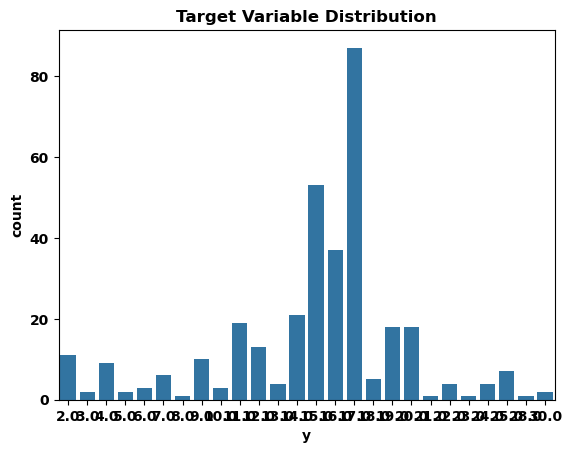

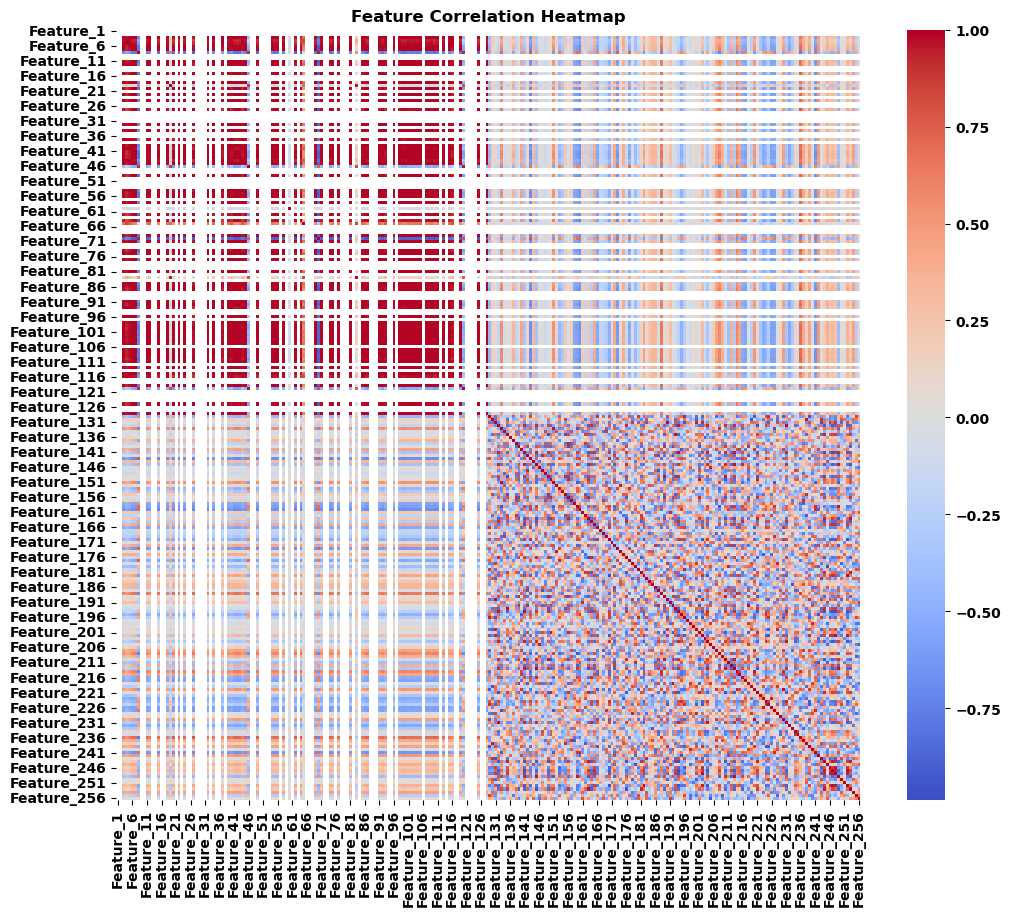

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import seaborn as sns


# Set random seed for reproducibility
seed = 42  # You can choose any integer here

# Set seed for NumPy
np.random.seed(seed)

# Set seed for Python's random module
random.seed(seed)

# Set seed for PyTorch
torch.manual_seed(seed)

# For GPU (if using CUDA)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

# Set deterministic behavior for reproducibility in case of CUDA operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False




dataset_dir = "datasets/no_comm_20/"

# Directory containing the saved CSV files
output_dir = dataset_dir + "training_outputs/"

# Load one of the CSV files for EDA (e.g., user_0_outputs.csv)
csv_file = os.path.join(output_dir, "user_1_outputs.csv")
df = pd.read_csv(csv_file)

# Quick overview of the data
print("Data Overview:")
print(df.head())
print("\nData Summary:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Distribution of the target variable (y)
sns.countplot(x="y", data=df)
plt.title("Target Variable Distribution")
plt.show()

# Correlation heatmap of features
correlation_matrix = df.iloc[:, :-1].corr()  # Exclude the target column
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [2]:
no_users = 20
# Define the Multinomial Logistic Regression model
class MultinomialLogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MultinomialLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

# Custom dataset to load the data from CSV
class CustomDataset(Dataset):
    def __init__(self,  csv_file, modality=["pos_height", "images"], scaler=None, zero_prob=0.5):
        self.data = pd.read_csv(csv_file)
        if "images" in modality and "pos_height" in modality:
            self.X = self.data.iloc[:, :-1].values  # Features
            mask = np.ones(self.X.shape)  # Initialize mask
            mask[:, 128:-1] = np.random.choice([0, 1], size=self.X[:, 128:-1].shape, p=[zero_prob, 1 - zero_prob])
            self.X *= mask  # Apply mask to zero out features
        elif "images" in modality:
            self.X = self.data.iloc[:, 128:-1].values  # Features
            mask = np.random.choice([0, 1], size=self.X.shape, p=[zero_prob, 1 - zero_prob])  # Create a binary mask
            self.X *= mask  # Apply mask
        else:
            self.X = self.data.iloc[:, 0:128].values  # Features

        self.y = self.data.iloc[:, -1].values   # Labels

        # If a scaler is provided, use it to transform the features
        if scaler:
            self.X = scaler.transform(self.X)
        else:
            # Fit the scaler on the training data and transform
            self.scaler = MinMaxScaler(feature_range=(-1, 1))
            self.X = self.scaler.fit_transform(self.X)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.long)  # Use long for classification targets
        return X, y



In [3]:
# Configuration
no_users = 20  # Example: Number of users
available_modalities = ["pos_height", "images"]
modality_size = {"pos_height": 128, "images": 128}
group_definitions = {
    1: ["pos_height"],        # Group 1: Only pos_height
    2: ["images"],            # Group 2: Only images
    3: ["pos_height", "images"]  # Group 3: Both modalities
}

# Assign each user to a group randomly
user_groups = [random.choice([1, 2, 3]) for _ in range(no_users)]

# Assign modalities to users based on their group
user_modalities = [group_definitions[group] for group in user_groups]

# Compute output sizes for each user based on their modalities
output_sizes = [sum(modality_size[modality] for modality in user_modality) for user_modality in user_modalities]

# Store models (placeholders for actual models)
all_models = []

# Example output (for verification)
print(f"User Groups: {user_groups[:10]}")  # Show first 10 users' groups
print(f"User Modalities: {user_modalities[:10]}")  # Show first 10 users' modalities
print(f"Output Sizes: {output_sizes[:10]}")  # Show first 10 users' output sizes

User Groups: [3, 1, 1, 3, 2, 1, 1, 1, 3, 1]
User Modalities: [['pos_height', 'images'], ['pos_height'], ['pos_height'], ['pos_height', 'images'], ['images'], ['pos_height'], ['pos_height'], ['pos_height'], ['pos_height', 'images'], ['pos_height']]
Output Sizes: [256, 128, 128, 256, 128, 128, 128, 128, 256, 128]


In [4]:
no_users = 20
# List to store DataLoader objects for each user
train_loaders = []
val_loaders = []
test_loaders = []
scaler = None
# Loop over each user
zero_prob=0.9
dataset_dir = "datasets/no_comm_20/"
for user_idx in range(no_users):
    scaler = None
    # Define file paths for each user dynamically
    train_file = dataset_dir + f"training_outputs/user_{user_idx}_outputs.csv"
    val_file = dataset_dir + f"val_outputs/user_{user_idx}_outputs.csv"
    test_file = dataset_dir + f"test_outputs/user_{user_idx}_outputs.csv"

    # Load training data and fit the scaler on it (only once for each user)
    train_data = pd.read_csv(train_file)
    
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        # Fit the scaler on the first user's training data
        if "images" in user_modalities[user_idx] and "pos_height" in user_modalities[user_idx]:
            temp = train_data.iloc[:, :-1].values  # Features
        elif "images" in user_modalities[user_idx]:
            temp = train_data.iloc[:, 128:-1].values  # Features
        else:
            temp = train_data.iloc[:, 0:128].values  # Features
        scaler.fit(temp)  # Fit scaler only on training features

    # Create datasets using the same scaler for all data
    train_dataset = CustomDataset(train_file, scaler=scaler, modality=user_modalities[user_idx], zero_prob=0.5)
    val_dataset = CustomDataset(val_file, scaler=scaler, modality=user_modalities[user_idx], zero_prob=0.5)
    test_dataset = CustomDataset(test_file, scaler=scaler, modality=user_modalities[user_idx], zero_prob=0.5)

    # Create DataLoader for training, validation, and testing for each user
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Append each user's DataLoader to the respective lists
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)
    test_loaders.append(test_loader)

In [5]:
# Initialize model, loss function, and optimizer for multiple users
input_sizes = output_sizes  # Number of features
num_classes = 64
classifiers = [MultinomialLogisticRegression(input_size, num_classes) for input_size, _ in zip(input_sizes, range(no_users))]
#classifiers = [MultinomialLogisticRegression(input_size, num_classes).cuda() for _ in range(no_users)]
optimizers = [optim.SGD(model.parameters(), lr=0.01) for model in classifiers]
criterion = nn.CrossEntropyLoss()
# Training parameters
num_epochs = 100

In [6]:
from utils import cross_entropy_loss_with_l2
loss_func = cross_entropy_loss_with_l2

# Group assignments (use the previously defined user_groups)
group_losses = {1: [], 2: [], 3: []}
group_accuracies = {1: [], 2: [], 3: []}

# Initialize dictionaries to track metrics for each group
group_train_loss_histories = {1: [], 2: [], 3: []}
group_train_accuracy_histories = {1: [], 2: [], 3: []}
group_val_loss_histories = {1: [], 2: [], 3: []}
group_val_accuracy_histories = {1: [], 2: [], 3: []}
lambda_reg = 0.01
eta = 0.01
from utils import cross_entropy_loss_with_l2
# Training loop
for epoch in range(num_epochs):
    # Temporary dictionaries for this epoch
    epoch_group_train_losses = {1: [], 2: [], 3: []}
    epoch_group_train_accuracies = {1: [], 2: [], 3: []}
    epoch_group_val_losses = {1: [], 2: [], 3: []}
    epoch_group_val_accuracies = {1: [], 2: [], 3: []}

    for user_id, (model, optimizer) in enumerate(zip(classifiers, optimizers)):
        group = user_groups[user_id]  # Get the group of the user

        # Training phase
        model.train()
        epoch_train_loss = 0.0
        correct_train_predictions = 0
        total_train_samples = 0

        for X_batch, y_batch in train_loaders[user_id]:
            #X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            outputs = model(X_batch)
            loss = loss_func(model, X_batch, y_batch, l2_strength=0.001)#criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)
            correct_train_predictions += (predicted == y_batch).sum().item()
            total_train_samples += y_batch.size(0)

        avg_train_loss = epoch_train_loss / len(train_loaders[user_id])
        train_accuracy = correct_train_predictions / total_train_samples

        # Validation phase
        model.eval()
        epoch_val_loss = 0.0
        correct_val_predictions = 0
        total_val_samples = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loaders[user_id]:
                #X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
                outputs = model(X_batch)
                loss = loss_func(model, X_batch, y_batch, l2_strength=0.001)#criterion(outputs, y_batch)

                epoch_val_loss += loss.item()
                _, predicted = torch.max(outputs, dim=1)
                correct_val_predictions += (predicted == y_batch).sum().item()
                total_val_samples += y_batch.size(0)

        avg_val_loss = epoch_val_loss / len(val_loaders[user_id])
        val_accuracy = correct_val_predictions / total_val_samples

        # Assign metrics to the respective group
        epoch_group_train_losses[group].append(avg_train_loss)
        epoch_group_train_accuracies[group].append(train_accuracy)
        epoch_group_val_losses[group].append(avg_val_loss)
        epoch_group_val_accuracies[group].append(val_accuracy)

    # Calculate averages for this epoch and store them
    for group in [1, 2, 3]:
        #group_train_loss_histories[group].append(np.mean(epoch_group_train_losses[group]))
        #group_train_accuracy_histories[group].append(np.mean(epoch_group_train_accuracies[group]))
        #group_val_loss_histories[group].append(np.mean(epoch_group_val_losses[group]))
        #group_val_accuracy_histories[group].append(np.mean(epoch_group_val_accuracies[group]))
        group_train_loss_histories[group].append(epoch_group_train_losses[group])
        group_train_accuracy_histories[group].append(epoch_group_train_accuracies[group])
        group_val_loss_histories[group].append(epoch_group_val_losses[group])
        group_val_accuracy_histories[group].append(epoch_group_val_accuracies[group])

    # Print group-wise average metrics
    print(f"Epoch [{epoch+1}/{num_epochs}] Group Metrics:")
    for group in [1, 2, 3]:
        print(f"  Group {group} - Train Loss: {np.mean(epoch_group_train_losses[group]):.4f}, Train Accuracy: {np.mean(epoch_group_train_accuracies[group]):.4f}")
        print(f"  Group {group} - Val Loss: {np.mean(epoch_group_val_losses[group]):.4f}, Val Accuracy: {np.mean(epoch_group_val_accuracies[group]):.4f}")


C:\Users\aghalkha21\AppData\Local\Temp\ipykernel_20740\3432764924.py:42: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[idx], dtype=torch.long)  # Use long for classification targets


Epoch [1/100] Group Metrics:
  Group 1 - Train Loss: 4.1437, Train Accuracy: 0.0466
  Group 1 - Val Loss: 3.9321, Val Accuracy: 0.1600
  Group 2 - Train Loss: 4.1867, Train Accuracy: 0.0103
  Group 2 - Val Loss: 4.0892, Val Accuracy: 0.0234
  Group 3 - Train Loss: 4.0343, Train Accuracy: 0.0695
  Group 3 - Val Loss: 3.6757, Val Accuracy: 0.2364
Epoch [2/100] Group Metrics:
  Group 1 - Train Loss: 3.8004, Train Accuracy: 0.1888
  Group 1 - Val Loss: 3.6400, Val Accuracy: 0.2313
  Group 2 - Train Loss: 4.0072, Train Accuracy: 0.0513
  Group 2 - Val Loss: 3.9175, Val Accuracy: 0.1287
  Group 3 - Train Loss: 3.5044, Train Accuracy: 0.2537
  Group 3 - Val Loss: 3.2936, Val Accuracy: 0.2698
Epoch [3/100] Group Metrics:
  Group 1 - Train Loss: 3.5289, Train Accuracy: 0.2338
  Group 1 - Val Loss: 3.4228, Val Accuracy: 0.2408
  Group 2 - Train Loss: 3.8388, Train Accuracy: 0.1597
  Group 2 - Val Loss: 3.7585, Val Accuracy: 0.2515
  Group 3 - Train Loss: 3.1904, Train Accuracy: 0.2599
  Group 3 

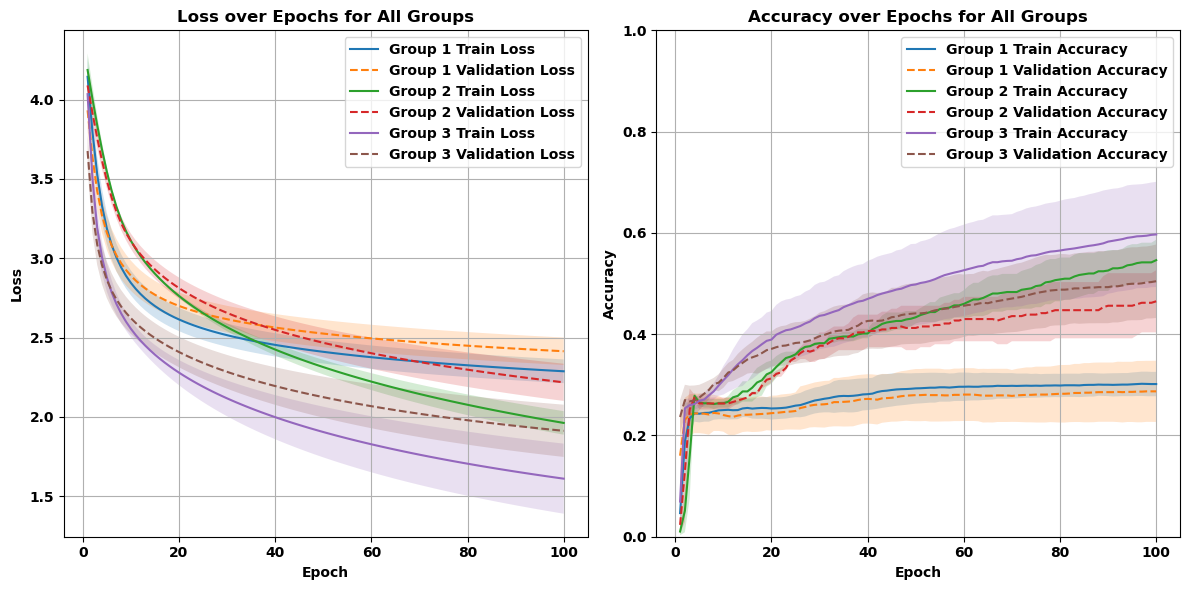

In [7]:
# Convert metrics to numpy arrays for easy manipulation
group_train_loss_histories = {k: np.array(v) for k, v in group_train_loss_histories.items()}
group_train_accuracy_histories = {k: np.array(v) for k, v in group_train_accuracy_histories.items()}
group_val_loss_histories = {k: np.array(v) for k, v in group_val_loss_histories.items()}
group_val_accuracy_histories = {k: np.array(v) for k, v in group_val_accuracy_histories.items()}

# Handle potential one-dimensional arrays
group_train_loss_mean = {k: v.mean(axis=1) if v.ndim > 1 else v for k, v in group_train_loss_histories.items()}
group_train_loss_std = {k: v.std(axis=1) if v.ndim > 1 else np.zeros_like(v) for k, v in group_train_loss_histories.items()}
group_val_loss_mean = {k: v.mean(axis=1) if v.ndim > 1 else v for k, v in group_val_loss_histories.items()}
group_val_loss_std = {k: v.std(axis=1) if v.ndim > 1 else np.zeros_like(v) for k, v in group_val_loss_histories.items()}

group_train_acc_mean = {k: v.mean(axis=1) if v.ndim > 1 else v for k, v in group_train_accuracy_histories.items()}
group_train_acc_std = {k: v.std(axis=1) if v.ndim > 1 else np.zeros_like(v) for k, v in group_train_accuracy_histories.items()}
group_val_acc_mean = {k: v.mean(axis=1) if v.ndim > 1 else v for k, v in group_val_accuracy_histories.items()}
group_val_acc_std = {k: v.std(axis=1) if v.ndim > 1 else np.zeros_like(v) for k, v in group_val_accuracy_histories.items()}

# Combined Plot for All Modalities
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
for group in [1, 2, 3]:
    plt.plot(range(1, num_epochs + 1), group_train_loss_mean[group], label=f"Group {group} Train Loss")
    plt.fill_between(range(1, num_epochs + 1), 
                     group_train_loss_mean[group] - group_train_loss_std[group], 
                     group_train_loss_mean[group] + group_train_loss_std[group], 
                     alpha=0.2)
    plt.plot(range(1, num_epochs + 1), group_val_loss_mean[group], label=f"Group {group} Validation Loss", linestyle="dashed")
    plt.fill_between(range(1, num_epochs + 1), 
                     group_val_loss_mean[group] - group_val_loss_std[group], 
                     group_val_loss_mean[group] + group_val_loss_std[group], 
                     alpha=0.2)

plt.title("Loss over Epochs for All Groups")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Accuracy Plot
plt.subplot(1, 2, 2)
for group in [1, 2, 3]:
    plt.plot(range(1, num_epochs + 1), group_train_acc_mean[group], label=f"Group {group} Train Accuracy")
    plt.fill_between(range(1, num_epochs + 1), 
                     group_train_acc_mean[group] - group_train_acc_std[group], 
                     group_train_acc_mean[group] + group_train_acc_std[group], 
                     alpha=0.2)
    plt.plot(range(1, num_epochs + 1), group_val_acc_mean[group], label=f"Group {group} Validation Accuracy", linestyle="dashed")
    plt.fill_between(range(1, num_epochs + 1), 
                     group_val_acc_mean[group] - group_val_acc_std[group], 
                     group_val_acc_mean[group] + group_val_acc_std[group], 
                     alpha=0.2)

plt.title("Accuracy over Epochs for All Groups")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])  # Ensure y-axis is between 0 and 1 for accuracy
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


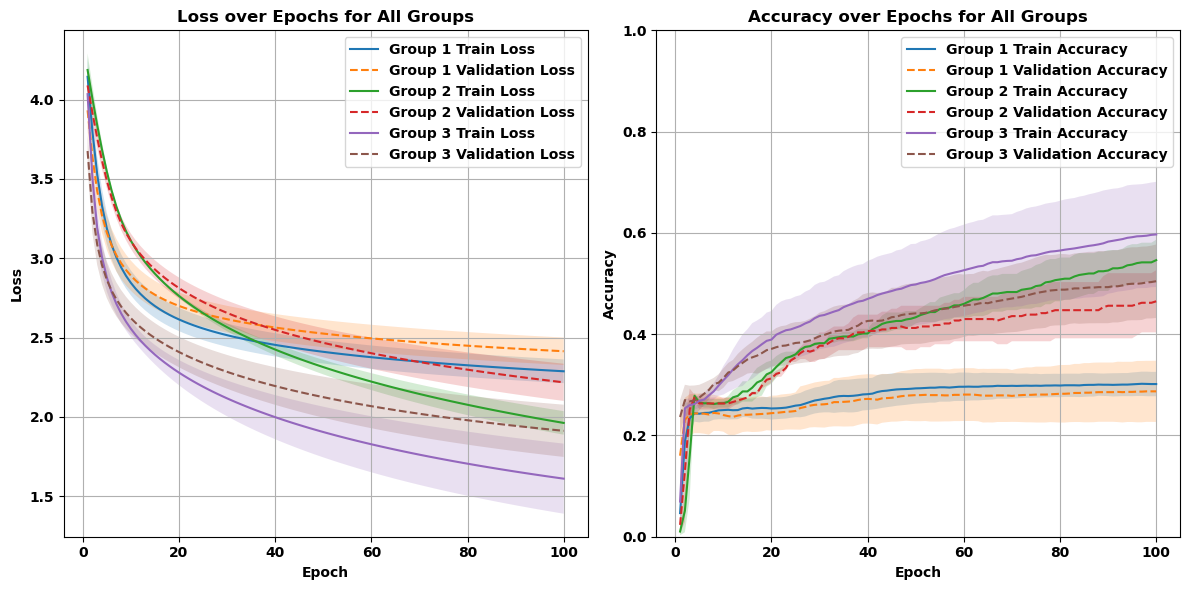

In [8]:
# Combined Plot for All Modalities
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
for group in [1, 2, 3]:
    plt.plot(range(1, num_epochs + 1), group_train_loss_mean[group], label=f"Group {group} Train Loss")
    plt.fill_between(range(1, num_epochs + 1), 
                     group_train_loss_mean[group] - group_train_loss_std[group], 
                     group_train_loss_mean[group] + group_train_loss_std[group], 
                     alpha=0.2)
    plt.plot(range(1, num_epochs + 1), group_val_loss_mean[group], label=f"Group {group} Validation Loss", linestyle="dashed")
    plt.fill_between(range(1, num_epochs + 1), 
                     group_val_loss_mean[group] - group_val_loss_std[group], 
                     group_val_loss_mean[group] + group_val_loss_std[group], 
                     alpha=0.2)

plt.title("Loss over Epochs for All Groups")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Accuracy Plot
plt.subplot(1, 2, 2)
for group in [1, 2, 3]:
    plt.plot(range(1, num_epochs + 1), group_train_acc_mean[group], label=f"Group {group} Train Accuracy")
    plt.fill_between(range(1, num_epochs + 1), 
                     group_train_acc_mean[group] - group_train_acc_std[group], 
                     group_train_acc_mean[group] + group_train_acc_std[group], 
                     alpha=0.2)
    plt.plot(range(1, num_epochs + 1), group_val_acc_mean[group], label=f"Group {group} Validation Accuracy", linestyle="dashed")
    plt.fill_between(range(1, num_epochs + 1), 
                     group_val_acc_mean[group] - group_val_acc_std[group], 
                     group_val_acc_mean[group] + group_val_acc_std[group], 
                     alpha=0.2)

plt.title("Accuracy over Epochs for All Groups")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])  # Ensure y-axis is between 0 and 1 for accuracy
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [9]:
# Track metrics across all groups
'''
group_test_loss_histories = {group: [] for group in range(1, num_groups + 1)}
group_test_accuracy_histories = {group: [] for group in range(1, num_groups + 1)}
group_train_loss_histories = {group: [] for group in range(1, num_groups + 1)}
group_train_accuracy_histories = {group: [] for group in range(1, num_groups + 1)}

with torch.no_grad():  # Disable gradient computation for testing
    for group in range(1, num_groups + 1):
        user_test_losses = []
        user_test_accuracies = []
        user_train_losses = []
        user_train_accuracies = []

        for user_id, model in enumerate(classifiers_by_group[group]):
            model.eval()

            # Test metrics
            epoch_test_loss = 0.0
            correct_test_predictions = 0
            total_test_samples = 0

            # Train metrics (optional, for post-training evaluation on training data)
            epoch_train_loss = 0.0
            correct_train_predictions = 0
            total_train_samples = 0

            # Evaluate on test set
            for X_batch, y_batch in test_loaders_by_group[group][user_id]:
                X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                epoch_test_loss += loss.item()
                _, predicted = torch.max(outputs, dim=1)
                correct_test_predictions += (predicted == y_batch).sum().item()
                total_test_samples += y_batch.size(0)

            # Evaluate on training set
            for X_batch, y_batch in train_loaders_by_group[group][user_id]:
                X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                epoch_train_loss += loss.item()
                _, predicted = torch.max(outputs, dim=1)
                correct_train_predictions += (predicted == y_batch).sum().item()
                total_train_samples += y_batch.size(0)

            # Calculate averages
            avg_test_loss = epoch_test_loss / len(test_loaders_by_group[group][user_id])
            test_accuracy = correct_test_predictions / total_test_samples

            avg_train_loss = epoch_train_loss / len(train_loaders_by_group[group][user_id])
            train_accuracy = correct_train_predictions / total_train_samples

            # Store metrics for each user
            user_test_losses.append(avg_test_loss)
            user_test_accuracies.append(test_accuracy)
            user_train_losses.append(avg_train_loss)
            user_train_accuracies.append(train_accuracy)

        # Store group-level metrics
        group_test_loss_histories[group].append(np.mean(user_test_losses))
        group_test_accuracy_histories[group].append(np.mean(user_test_accuracies))
        group_train_loss_histories[group].append(np.mean(user_train_losses))
        group_train_accuracy_histories[group].append(np.mean(user_train_accuracies))

# Convert metrics to numpy arrays for plotting
group_test_loss_histories = {group: np.array(values) for group, values in group_test_loss_histories.items()}
group_test_accuracy_histories = {group: np.array(values) for group, values in group_test_accuracy_histories.items()}
group_train_loss_histories = {group: np.array(values) for group, values in group_train_loss_histories.items()}
group_train_accuracy_histories = {group: np.array(values) for group, values in group_train_accuracy_histories.items()}

# Plot results for all groups
plt.figure(figsize=(12, 6))

# Test Loss and Accuracy
plt.subplot(1, 2, 1)
for group in range(1, num_groups + 1):
    plt.plot(range(1, len(group_test_loss_histories[group]) + 1), group_test_loss_histories[group], label=f"Group {group} Test Loss")
plt.title("Test Loss Across Groups")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
for group in range(1, num_groups + 1):
    plt.plot(range(1, len(group_test_accuracy_histories[group]) + 1), group_test_accuracy_histories[group], label=f"Group {group} Test Accuracy")
plt.title("Test Accuracy Across Groups")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
'''

'\ngroup_test_loss_histories = {group: [] for group in range(1, num_groups + 1)}\ngroup_test_accuracy_histories = {group: [] for group in range(1, num_groups + 1)}\ngroup_train_loss_histories = {group: [] for group in range(1, num_groups + 1)}\ngroup_train_accuracy_histories = {group: [] for group in range(1, num_groups + 1)}\n\nwith torch.no_grad():  # Disable gradient computation for testing\n    for group in range(1, num_groups + 1):\n        user_test_losses = []\n        user_test_accuracies = []\n        user_train_losses = []\n        user_train_accuracies = []\n\n        for user_id, model in enumerate(classifiers_by_group[group]):\n            model.eval()\n\n            # Test metrics\n            epoch_test_loss = 0.0\n            correct_test_predictions = 0\n            total_test_samples = 0\n\n            # Train metrics (optional, for post-training evaluation on training data)\n            epoch_train_loss = 0.0\n            correct_train_predictions = 0\n            to

In [10]:
# Images only
'''
Test Loss: 0.4364, Test Accuracy: 0.8521

Train Loss: 0.4047, Train Accuracy: 0.8687

'''

'\nTest Loss: 0.4364, Test Accuracy: 0.8521\n\nTrain Loss: 0.4047, Train Accuracy: 0.8687\n\n'

In [11]:
import json
import os

# Define the save directory


# Convert numpy arrays to lists for serialization
data_to_save = {
    "group_train_loss_mean": {k: v.tolist() for k, v in group_train_loss_mean.items()},
    "group_train_loss_std": {k: v.tolist() for k, v in group_train_loss_std.items()},
    "group_val_loss_mean": {k: v.tolist() for k, v in group_val_loss_mean.items()},
    "group_val_loss_std": {k: v.tolist() for k, v in group_val_loss_std.items()},
    "group_train_acc_mean": {k: v.tolist() for k, v in group_train_acc_mean.items()},
    "group_train_acc_std": {k: v.tolist() for k, v in group_train_acc_std.items()},
    "group_val_acc_mean": {k: v.tolist() for k, v in group_val_acc_mean.items()},
    "group_val_acc_std": {k: v.tolist() for k, v in group_val_acc_std.items()}
}

with open("No_Comm_Metrics_20.json", "w") as f:
    json.dump(data_to_save, f)
print("No_Comm_Metrics_20.json")

No_Comm_Metrics_20.json
